# Part II - Investigating the Flight Data In 2007 from the Bureau of Transportation Statistics

## by Chidiebere Chukwuemeka

## Investigation Overview


> The main interest in my dataset will be to understand why or the major causes of flight cancelations and delays. We shall explore characteristics of trips made and what insights the company would need to improve their system.


## Dataset Overview

> The 2007 Flight dataset contains 7453215 entries and 29 columns(representing features in the dataset). The features of interest will be the `Month`, `Distance`, `TaxiIn`,`TaxiOut`, `CarrierDelay`, `WeatherDelay`, `SecurityDelay`, `LateAircraftDelay`, `AirTime`, `ArrDelay`, `DepDelay`, `Cancellation`. We can use this to get insights that are neccessary for the research.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# suppress warnings from final output
#import warnings
#warnings.simplefilter("ignore")

In [2]:
# load in the dataset into a pandas dataframe
# Importing the 2007 flight dataset
flight_df = pd.read_csv("2007.csv")

In [3]:
#Converting the numerical equivalent of week using the replace function
flight_df["DayOfWeek"] = flight_df["DayOfWeek"].replace({
        "1": "Mon",
        "2": "Tue",
        "3": "Wed",
        "4": "Thu",
        "5": "Fri",
        "6": "Sat",
        "7": "Sun"
})

#Converting flight cancellation
flight_df["CancellationCode"] = flight_df["CancellationCode"].replace({
    "A": "Carrier",
    "B": "Weather",
    "C": "National Air System",
    "D": "Security"
})

#Using the rename function to change CancellationCode to Cancellation since it no longer is a Coded feature
flight_df.rename(index = int, columns={"CancellationCode" : "Cancellation"}, inplace = True)

#Converting to strings
flight_df[["DayOfWeek"]] = flight_df[["DayOfWeek"]].astype('string')
flight_df[["Month"]] = flight_df[["Month"]].astype('string')

#Making a copy of the original data collected
flight_clean = flight_df.copy()

# for color in the data set
base_color = sns.color_palette()[3]

# In other to stop repeated codes we can automate some parts of the codes such as the title and labels going forward
def plot_label(title, x_label, y_label):
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.xticks(rotation=90)

## What is the distibution of the Distance in miles covered by the flights?

> The Log transform was plotted and shows that majority of the flights had a low distance coverage and the data is unimodal because it has only one peak around the 500miles distance covered then it begins to go down.

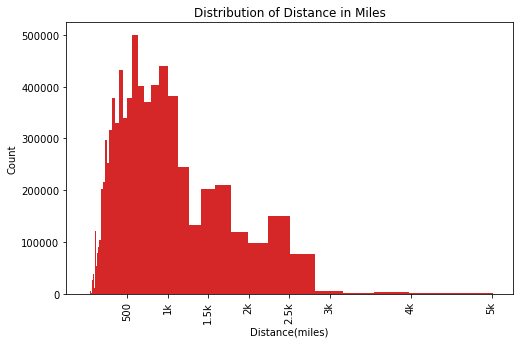

In [4]:
log_binsize = 0.05
bin_edges = 10 ** np.arange(0, np.log10(flight_clean["Distance"].max())+log_binsize, log_binsize)


plt.figure(figsize = [8, 5])
plt.hist(data = flight_clean, x = "Distance", color = base_color, bins = bin_edges)
plot_label("Distribution of Distance in Miles", "Distance(miles)", "Count")
plt.xticks([500, 1e3, 1500, 2e3, 2500, 3e3, 4e3, 5e3], [500, "1k", "1.5k", "2k", "2.5k", "3k", "4k", "5k"])
plt.show()

## What is the distribution of the Arrival and Departure delays?

> It is interesting to note the similarity in the plots for arrival delays and departure delays. Both plots are skewed to the right to a great degree. The graph of both arival and departure delays were both unimodal as majority delays were below 50mins.

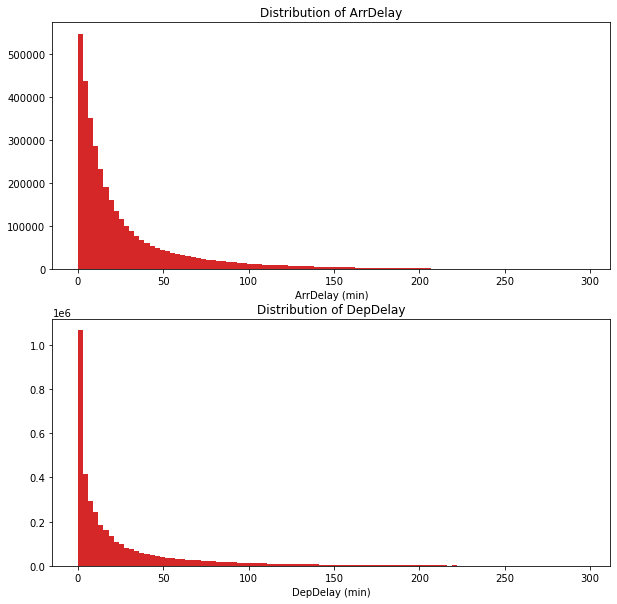

In [5]:
fig, ax = plt.subplots(nrows = 2, figsize = [10, 10])

delay_variables = ["ArrDelay", "DepDelay"]
for i in range(len(delay_variables)):
    var = delay_variables[i]
    bins = np.arange(0, 300, 3)
    ax[i].hist(data = flight_clean, x = var, bins = bins, color = base_color)
    ax[i].set_xlabel('{} (min)'.format(var))
    ax[i].set_title("Distribution of {}".format(var))

plt.show()

## What is the relationship between Departure and Arrival Delay when flights are not cancelled?

> This plot shows a strong correlation for Departure and Arrival Delay when fights are not cancelled.

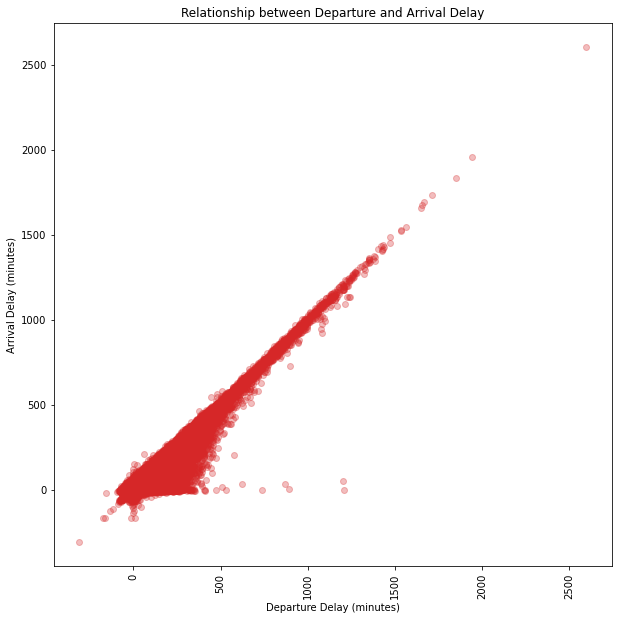

In [6]:
#Define plot
plt.figure(figsize=(10,10))
plt.scatter(data = flight_clean.query("Cancelled==0"), x="ArrDelay", y="DepDelay", alpha = 0.3, color = base_color)
plot_label("Relationship between Departure and Arrival Delay","Departure Delay (minutes)","Arrival Delay (minutes)")

## What are the monthly trends in delay pattern and what type of delays are most frequent monthly?
> It is clear from the graph above that monthly delays caused by weather and late air craft have a greater overall impact than delays caused by other factors. Additionally, it also can be seen that the delays vary greatly from month to month while the least frequent and least variable delays are those brought on by security concerns.
The results of multivariate analysis support the conclusion that monthly delays were primarily caused by the weather and late air craft delays.

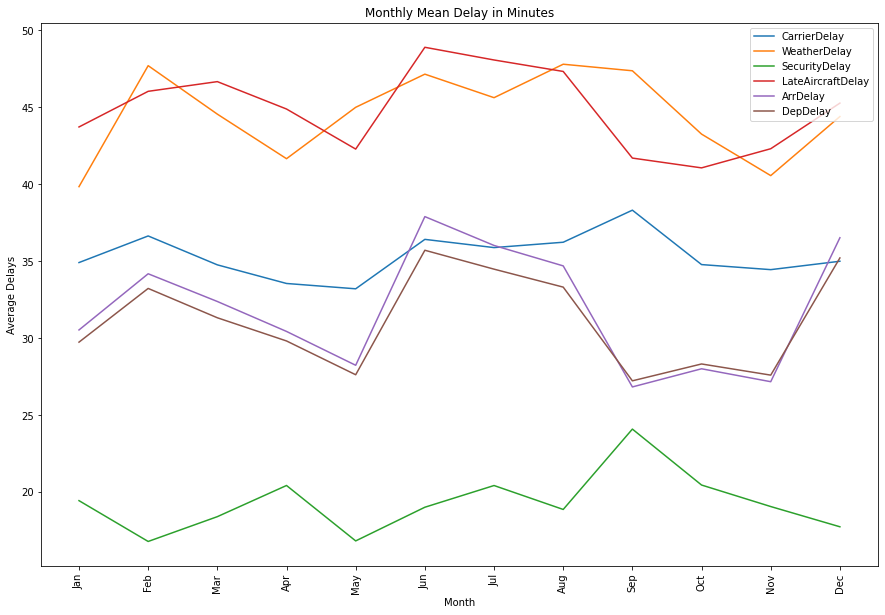

In [7]:
#Converting the numerical equivalent of months using the replace function
flight_clean["Month"] = flight_clean["Month"].replace({
        "1": "Jan",
        "2": "Feb",
        "3": "Mar",
        "4": "Apr",
        "5": "May",
        "6": "Jun",
        "7": "Jul",
        "8": "Aug",
        "9": "Sep",
        "10": "Oct",
        "11": "Nov",
        "12": "Dec"
})

#Creating dataframes that will group each delay by month and calculate average delay for each
Monthly_CarrierDelay =flight_clean.query("CarrierDelay>0").groupby("Month")["CarrierDelay"].mean().reset_index(name="CarrierDelay")
Monthly_WeatherDelay =flight_clean.query("WeatherDelay>0").groupby("Month")["WeatherDelay"].mean().reset_index(name="WeatherDelay")
Monthly_SecurityDelay =flight_clean.query("SecurityDelay>0").groupby("Month")["SecurityDelay"].mean().reset_index(name="SecurityDelay")
Monthly_LateAircraftDelay =flight_clean.query("LateAircraftDelay>0").groupby("Month")["LateAircraftDelay"].mean().reset_index(name="LateAircraftDelay")
Monthly_DepDelay =flight_clean.query("DepDelay>0").groupby("Month")["DepDelay"].mean().reset_index(name="DepDelay")
Monthly_ArrDelay =flight_clean.query("ArrDelay>0").groupby("Month")["ArrDelay"].mean().reset_index(name="ArrDelay")

#Joining all these dataframes into one
Merger = Monthly_CarrierDelay.merge(Monthly_WeatherDelay,on="Month")
Merger = Merger.merge(Monthly_SecurityDelay,on="Month")
Merger = Merger.merge(Monthly_LateAircraftDelay,on="Month")
Merger = Merger.merge(Monthly_DepDelay, on="Month")
Monthly_Delays = Merger.merge(Monthly_ArrDelay, on="Month")

#Reindexing the data
Monthly_Delays = Monthly_Delays.reindex([4, 3, 7, 0, 8, 6, 5, 1, 11, 10, 9, 2])
#using the melt function to arrange the data for easy plots
Monthly_Melt = pd.melt(Monthly_Delays, id_vars=["Month"], value_vars=["CarrierDelay", "WeatherDelay", "SecurityDelay", "LateAircraftDelay", "ArrDelay", "DepDelay"])


#Define line plot
plt.figure(figsize=(15,10))
c = sns.lineplot(data = Monthly_Melt, x = "Month", y = "value", hue="variable" )
plt.legend(loc = "upper right")
plot_label("Monthly Mean Delay in Minutes", "Month", "Average Delays")
plt.show();
